# Import

In [1]:
# Numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Stable baselines
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

# Custom modules
import sys
import os
local_path = '/Users/riccardo/Documents/GitHub/' #'path_to_progect_folder/'
sys.path.append(local_path+'OptimalControlAttacks/SyntheticDataExperiments/')
from Modules import AuxiliaryFunctions as AF
from Modules import GreedyAttacks as GA
from Modules import DeepRLAttacks as RLA
from Parameters import ParametersAttacksComparison_2LayerNN as Par

# Colors

In [2]:
orange = '#F5A962'
light_blue = '#3C8DAD'

# Parameters

In [3]:
# Model
model_name = Par.model_name
activation = Par.activation
output_scaling = Par.output_scaling
hiddenlayer_width = Par.hiddenlayer_width
target_type = Par.target_type
train_first_layer = Par.train_first_layer

# Input data parameters
dim_input = Par.dim_input
batch_size = Par.batch_size
mu_x = Par.mu_x
sigma_x = Par.sigma_x
n_runs_experiments = Par.n_runs_experiments

# Dynamics parameters
learning_rate = Par.learning_rate
gamma = Par.gamma
beta = Par.beta

# N. samples
n_timesteps = Par.n_timesteps
n_timesteps_transient_th = Par.n_timesteps_transient_th
n_timesteps_past = Par.n_timesteps_past
n_samples_average = Par.n_samples_average
n_samples_buffer = Par.n_samples_buffer
n_samples_test = Par.n_samples_test
time_window = Par.time_window

# Control parameters
a_min = Par.a_min
a_max = Par.a_max
n_a_gridpoints = Par.n_a_gridpoints
n_runs_calibration = Par.n_runs_calibration
control_cost_weight = Par.control_cost_weight
greedy_weight_future = Par.greedy_weight_future
opt_pref = Par.opt_pref
fut_pref = Par.fut_pref

# DeepRL Agent
agent_model_name = Par.agent_model_name
n_actions = Par.n_actions
use_action_noise = Par.use_action_noise
action_noise_mean = Par.action_noise_mean
action_noise_std = Par.action_noise_std
observation_type = Par.observation_type 
use_small_achitecture = Par.use_small_achitecture
shuffle_array = Par.shuffle_array
learning_rate_agent = Par.learning_rate_agent
activation_fn = Par.activation_fn
n_episodes = Par.n_episodes
save_freq = Par.save_freq
train_freq = Par.train_freq

# Strings/paths
experiment_description = Par.experiment_description
path_agent = Par.path_agent
export_path = Par.export_path
rlmodels_path = Par.rlmodels_path

In [4]:
print('dim_input:', dim_input)
print('hiddenlayer_width:', hiddenlayer_width)
print('output_scaling:', output_scaling)
print('target_type:', target_type)
print('batch_size:', batch_size)
print('activation:', activation)
print('a min:', a_min)
print('a max:', a_max)
print('observation_type:', observation_type)
print('control_cost_weight:', control_cost_weight)
print('N past timesteps:', n_timesteps_past)

dim_input: 10
hiddenlayer_width: 100
output_scaling: inv_sqroot
target_type: FlippedTeacher
batch_size: 1
activation: Erf
a min: -2
a max: 3
observation_type: lastlayer
control_cost_weight: 1.0
N past timesteps: 10000


# Arrays

In [5]:
# Seed
np.random.seed(seed=0)

# Teacher
W_teach = np.random.normal(0, 1, (hiddenlayer_width, dim_input))
W_teach = W_teach / (np.sum(W_teach**2, axis=1).reshape(-1,1).repeat(dim_input, axis=1)/dim_input)**0.5
v_teach = np.random.normal(0, 1, hiddenlayer_width)
v_teach = v_teach / ((np.sum(v_teach**2)/hiddenlayer_width))**0.5
# Target
if target_type=='FlippedTeacher':
    W_target = W_teach.copy()
    v_target = -v_teach.copy()
elif target_type=='Random':
    W_target = np.random.normal(0, 1, (hiddenlayer_width, dim_input))
    W_target = W_target / (np.sum(W_target**2, axis=1).reshape(-1,1).repeat(dim_input, axis=1)/dim_input)**0.5
    v_target = np.random.normal(0, 1, hiddenlayer_width)
    v_target = v_target / ((np.sum(v_target**2)/hiddenlayer_width))**0.5
# Student (initial condition)
W_stud_0 = W_teach.copy()
v_stud_0 = v_teach.copy()
            
# Arrays (assuming batch_size as specified above)
x_incoming_arr = np.random.normal(mu_x, sigma_x, (n_runs_experiments, batch_size*n_timesteps, dim_input))
x_past = np.random.normal(mu_x, sigma_x, (batch_size*n_timesteps_past, dim_input))
x_buffer = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_buffer, dim_input))
x_test = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_test, dim_input))

# Weight action cost

In [6]:
label_t_test = GA.NN2L(x_test, W_teach, v_teach, activation=activation, output_scaling=output_scaling)
label_o_test = GA.NN2L(x_test, W_target, v_target, activation=activation, output_scaling=output_scaling)
error_target_teach = np.mean((label_o_test-label_t_test)**2)
d_target_teach = 0.5 * error_target_teach
pref_control_cost_weight = (2*d_target_teach)
print('Pre-factor control cost: %.2f' % pref_control_cost_weight)

Pre-factor control cost: 3.24


## Check environment

In [7]:
print('Shuffle past stream:', shuffle_array)
env = RLA.EnvironmentNN2L(observation_type=observation_type,
                          x_arr=x_past,
                          batch_size=batch_size,
                          W_stud_0=W_stud_0, 
                          v_stud_0=v_stud_0,
                          W_teach=W_teach, 
                          v_teach=v_teach, 
                          W_target=W_target, 
                          v_target=v_target, 
                          a_min=a_min,
                          a_max=a_max,
                          learning_rate=learning_rate, 
                          control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                          activation=activation,
                          shuffle_array=shuffle_array, 
                          outputscaling=output_scaling, 
                          train_first_layer=train_first_layer)

check_env(env, warn=True)

Shuffle past stream: True


/opt/anaconda3/envs/OptimalControlAttacks/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:428: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


# RL agent

In [8]:
# Small architecture
if use_small_achitecture:
    print('Using custom small architecture for policy and value!')
    custom_net_kwargs = dict(activation_fn=activation_fn, net_arch=dict(pi=[10, 10], qf=[10, 10]))
else:
    custom_net_kwargs = None
         
# Create model
if agent_model_name=='TD3':
    
        if use_action_noise:
            action_noise = NormalActionNoise(mean=action_noise_mean, sigma=action_noise_std)
        else:
            action_noise = None  
            
        model = TD3("MlpPolicy", 
                    env,
                    action_noise=action_noise,
                    verbose=0, 
                    gamma=gamma,
                    learning_rate=learning_rate_agent, 
                    policy_kwargs=custom_net_kwargs,
                    train_freq=train_freq, 
                    gradient_steps=train_freq)
        print('New %s agent created' % agent_model_name)
else:
    raise ValueError('Agent type other than TD3 not available/tested')

New TD3 agent created


# Training agent

In [9]:
print('timesteps for each episode:', n_timesteps_past)

# Save a checkpoint 
checkpoint_callback = CheckpointCallback(
  save_freq=save_freq,
  save_path=path_agent,
  name_prefix="rl_model",
  save_replay_buffer=False,
  save_vecnormalize=True,
)

for ep in range(n_episodes):
    print('Episode: %d/%d'%(ep+1, n_episodes))
    model.learn(total_timesteps=n_timesteps_past, 
                progress_bar=False, 
                reset_num_timesteps=False,
                tb_log_name='DeepRL', 
                log_interval=1, 
                callback=checkpoint_callback)
        
print('Training completed!')

timesteps for each episode: 10000
Episode: 1/8
Episode: 2/8
Episode: 3/8
Episode: 4/8
Episode: 5/8
Episode: 6/8
Episode: 7/8
Episode: 8/8
Training completed!


## Compute training performance

In [10]:
timesteps = n_timesteps_past

steps = []
rew_disc_av = []

# Test environment
env = RLA.EnvironmentNN2L(observation_type=observation_type,
                          x_arr=x_test,
                          batch_size=batch_size,
                          W_stud_0=W_stud_0, 
                          v_stud_0=v_stud_0,
                          W_teach=W_teach, 
                          v_teach=v_teach, 
                          W_target=W_target, 
                          v_target=v_target, 
                          a_min=a_min,
                          a_max=a_max,
                          learning_rate=learning_rate, 
                          control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                          activation=activation,
                          shuffle_array=shuffle_array, 
                          outputscaling=output_scaling, 
                          train_first_layer=train_first_layer)
# Testing
for ep in range(n_episodes):
    
    for t in range(0, timesteps+1, save_freq):
        
        timesteps_past = ep*timesteps + t
        steps_flag = False

        if agent_model_name=='TD3':
            path_to_model = path_agent + f'/rl_model_{timesteps_past}_steps.zip'
            #path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
            if os.path.exists(path_to_model):
                model_iter = TD3.load(path_to_model, env)
                #model_iter.load_replay_buffer(path_to_buffer)
                print('Model: %d steps (episode %d)' % (timesteps_past, ep+1)) 
                steps_flag = True
            else:
                print('Model not found: %d steps (episode %d)' % (timesteps_past, ep+1)) 

        if steps_flag:
            reward_list = []
            obs, info = env.reset()
            terminated = False
            while not terminated:
                action, _ = model_iter.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                if env.timestep>=n_timesteps - time_window:
                    reward_list.append(reward)
                    
            rew_disc_av.append(np.mean(np.array(reward_list, dtype=object)))
            steps.append(timesteps_past)
        
objective = -np.array(rew_disc_av, dtype=object)
steps = np.array(steps, dtype=object)

Model not found: 0 steps (episode 1)
Model: 1000 steps (episode 1)
Model: 2000 steps (episode 1)
Model: 3000 steps (episode 1)
Model: 4000 steps (episode 1)
Model: 5000 steps (episode 1)
Model: 6000 steps (episode 1)
Model: 7000 steps (episode 1)
Model: 8000 steps (episode 1)
Model: 9000 steps (episode 1)
Model: 10000 steps (episode 1)
Model: 10000 steps (episode 2)
Model: 11000 steps (episode 2)
Model: 12000 steps (episode 2)
Model: 13000 steps (episode 2)
Model: 14000 steps (episode 2)
Model: 15000 steps (episode 2)
Model: 16000 steps (episode 2)
Model: 17000 steps (episode 2)
Model: 18000 steps (episode 2)
Model: 19000 steps (episode 2)
Model: 20000 steps (episode 2)
Model: 20000 steps (episode 3)
Model: 21000 steps (episode 3)
Model: 22000 steps (episode 3)
Model: 23000 steps (episode 3)
Model: 24000 steps (episode 3)
Model: 25000 steps (episode 3)
Model: 26000 steps (episode 3)
Model: 27000 steps (episode 3)
Model: 28000 steps (episode 3)
Model: 29000 steps (episode 3)
Model: 3000

## Export training performance

In [11]:
models_description = '_agent#%s' % (agent_model_name)
name = 'ObjectiveVSTrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = objective
np.save(rlmodels_path + filename, data_to_export)


models_description = '_agent#%s' % (agent_model_name)
name = 'TrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = steps
np.save(rlmodels_path + filename, data_to_export)

## Plot training performance

In [21]:
# Greedy average reward
if activation=='Linear':
    pref_fut = 1.
elif activation=='Erf':
    pref_fut = 1.6 # 2
reward_greedy_list = []

# Greedy experiment
obs, info = env.reset()
W_stud = env.W_stud
v_stud = env.v_stud
x_batch = env.x_batch
terminated = False
while not terminated:
    action = GA.a_greedy_NN2L(W_stud=W_stud,
                              v_stud=v_stud,
                              W_target=W_target,
                              v_target=v_target,
                              W_teach=W_teach,
                              v_teach=v_teach,
                              x_batch=x_batch,
                              x_buffer=x_buffer,
                              dim_input=dim_input,
                              eta=learning_rate,
                              weight_future=pref_fut*dim_input/learning_rate,
                              a_min=a_min,
                              a_max=a_max,
                              n_gridpoints=n_a_gridpoints,
                              control_cost_weight=pref_control_cost_weight*control_cost_weight,
                              activation=activation,
                              train_first_layer=train_first_layer,
                              output_scaling=output_scaling)
    
    obs, reward, terminated, truncated, info = env.step(action)
    W_stud, v_stud = env.W_stud, env.v_stud
    x_batch = env.x_batch
    if env.timestep>=n_timesteps - time_window:
        reward_greedy_list.append(reward)
    if env.timestep%100==0:
        print(env.timestep)
    
objective_greedy = -np.mean(np.array(reward_greedy_list, dtype=object))
objective_greedy, env.timestep

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


(0.5487366116756446, 9999)

In [22]:
# Find best model
best_model_t = steps[np.argmin(objective)]
best_model_obj = objective[np.argmin(objective)]
best_model_t, best_model_obj

(72000, 0.5610655517715738)

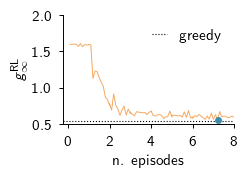

In [25]:
AF.SetPlotParams(magnification=.9, ratio=float(2.2/3.), fontsize=11, lines_w=.7, ms=7)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')


plt.axhline(objective_greedy, color='black', ls=':', lw=.8, label='greedy')
plt.plot(steps+1, objective, color=orange)
plt.plot(best_model_t, best_model_obj, color=light_blue, ls='', marker='.', ms=8)

plt.ylabel('$g^{\mathrm{RL}}_{\infty}$')
plt.xlabel('n. episodes')
plt.xlim([-n_timesteps_past/4, n_episodes*n_timesteps_past])
x_positions_ticks = np.linspace(0, n_episodes, n_episodes//2+1)*n_timesteps_past
x_ticks_labels = [int(x) for x in np.linspace(0, n_episodes, n_episodes//2+1)]
plt.xticks(x_positions_ticks, x_ticks_labels)
plt.yticks([0.5, 1., 1.5, 2.])
plt.ylim([0.5, 2.])
plt.grid(False)
plt.legend(loc=0)
plt.show()